In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers

# Procesamiento de datos

In [3]:
# Definir datos de train y test
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Shape de los datos
x_train.shape, y_test.shape

170498071/170498071 [==============================] - 6s 0us/step


((50000, 32, 32, 3), (10000, 1))

In [4]:
# Normalizar de datos X unicamente cuando no se estandarizan
x_train = x_train.astype('float32') #/255
x_test = x_test.astype('float32') #/255

# Definimos el numero de categorias
num_categorias = len(np.unique(y_train))

# Vectorizamos las categorias
y_train = to_categorical(y_train, num_categorias)
y_test = to_categorical(y_test, num_categorias)

# Dividir el set de datos en entrenamiento y validacion
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

# Capa de Batch Normalization

Agregamos un valor muy chiquito, como $1x10^{-7}$ el cual, nos permite que la std nunca sea 0 (fracciones indivisibles entre 0).

In [5]:
# Obtener media y std del set de entrenamiento
mean = np.mean(x_train)
std = np.std(x_train)

# Estandarizar los datos de train y test
x_train = (x_train  - mean)/(std + 1e-7)
x_test = (x_test  - mean)/(std + 1e-7)

# Creacion del modelo

El optimizador `optimizers.Adam()` se adecua bastante bien al momentum de la red, haciendo que se adecue mejor el optimizador.

In [6]:
# Definir variables del modelo
base_filtros = 32
w_regularizer = 1e-4

# Modelo
model = Sequential()

# Conv 1 con activacion
model.add(Conv2D(filters = base_filtros, kernel_size = (3,3), padding = 'same', 
                 kernel_regularizer = regularizers.l2(w_regularizer), input_shape = x_train.shape[1:] ))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv 2 con activacion, pooling y dropout
model.add(Conv2D(filters = base_filtros, kernel_size = (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.2))

# Conv 3 con activacion y dropout
model.add(Conv2D(filters = 2 * base_filtros, kernel_size = (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Conv 4 con activacion, pooling y dropout
model.add(Conv2D(filters = 2 * base_filtros, kernel_size = (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.3))

# Conv 5 con activacion
model.add(Conv2D(filters = 4 * base_filtros, kernel_size = (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Conv 6 con activacion, pooling y dropout
model.add(Conv2D(filters = 4 * base_filtros, kernel_size = (3,3), padding = 'same', kernel_regularizer = regularizers.l2(w_regularizer)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.4))

# Hacemos flatten y activamos con softmax para categorizar
model.add(Flatten())
model.add(Dense(num_categorias, activation = 'softmax'))

# Compilamos las funciones de optimizacion y coste
model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.Adam(), 
              metrics = ['accuracy'])

# Hacemos summary del modelo
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                        

# Data Augmentation

In [7]:
# Creamos el modulo ImageDataGenerator con los diferentes parametros
datagen = ImageDataGenerator(rotation_range= 15,
                  width_shift_range= 0.1,
                  height_shift_range= 0.1,
                  horizontal_flip= True, 
                  vertical_flip= True,
                  fill_mode = 'nearest',
                  brightness_range= [0.4, 1.5])

# Entrenamiento

In [8]:
# Entrenamiento normal

#hist = model.fit(x_train, y_train, batch_size=32,epochs=100,
#                validation_data=(x_valid, y_valid),
#                verbose=2, shuffle=True)

In [9]:
# Definimos el model checkpoint
checkpoint = ModelCheckpoint('CNN_reconocimiento_objetos.hdf5', verbose=1,
                             save_best_only= True, monitor = 'val_accuracy')

# Entrenamiento y validacion del modelo por DataGen
hist = model.fit( datagen.flow(x_train, y_train),
          callbacks = checkpoint,
          batch_size = 128,
          steps_per_epoch = x_train.shape[0] // 128,
          epochs = 30,
         validation_data= (x_valid, y_valid),
         verbose = 2, shuffle = True)

Epoch 1/30


2023-05-12 08:17:05.466178: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer



Epoch 1: val_accuracy improved from -inf to 0.12620, saving model to CNN_reconocimiento_objetos.hdf5
351/351 - 23s - loss: 2.7951 - accuracy: 0.2335 - val_loss: 81.1734 - val_accuracy: 0.1262 - 23s/epoch - 66ms/step
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.12620
351/351 - 12s - loss: 2.2918 - accuracy: 0.2884 - val_loss: 115.8407 - val_accuracy: 0.1020 - 12s/epoch - 35ms/step
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.12620
351/351 - 13s - loss: 2.0594 - accuracy: 0.3351 - val_loss: 113.7060 - val_accuracy: 0.1002 - 13s/epoch - 37ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.12620 to 0.16520, saving model to CNN_reconocimiento_objetos.hdf5
351/351 - 12s - loss: 1.9214 - accuracy: 0.3580 - val_loss: 73.7497 - val_accuracy: 0.1652 - 12s/epoch - 35ms/step
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.16520
351/351 - 13s - loss: 1.7965 - accuracy: 0.3886 - val_loss: 104.6820 - val_accuracy: 0.1454 - 13s/epoch - 37ms/step
Epoch 6/30

Epo

# Graficar Resultados

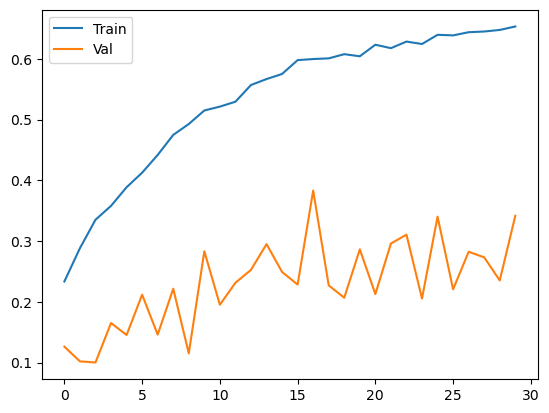

In [10]:
plt.plot(hist.history['accuracy'],label='Train')
plt.plot(hist.history['val_accuracy'],label='Val')
plt.legend()
plt.show()

# Usar mejor modelo

In [11]:
model2 = model
model2.load_weights('./CNN_reconocimiento_objetos.hdf5')
model2.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.2610 - accuracy: 0.5995


[1.2610405683517456, 0.5995000004768372]

In [12]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 1.2610 - accuracy: 0.5995


[1.2610405683517456, 0.5995000004768372]

In [13]:
model.history.params

{'verbose': 1, 'epochs': 1, 'steps': 313}